In [1]:
import torch
import torch.nn as nn

import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import os
import numpy as np
from IPython import display
import pandas as pd
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

/usr/local/lib/python3.9/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:


###pytorch functions imported from https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html
########pytorch audio formatting functions

import os
import math


import librosa


import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import time
from IPython.display import Audio, display

[width, height] = matplotlib.rcParams['figure.figsize']
if width < 10:
  matplotlib.rcParams['figure.figsize'] = [width * 2.5, height]

def _get_sample(path, resample=None):
  effects = [
    ["remix", "1"]
  ]
  if resample:
    effects.extend([
      ["lowpass", f"{resample // 2}"],
      ["rate", f'{resample}'],
    ])
  return torchaudio.sox_effects.apply_effects_file(path, effects=effects)

def get_speech_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_SPEECH_PATH, resample=resample)

def get_sample(*, resample=None):
  return _get_sample(SAMPLE_WAV_PATH, resample=resample)

def get_rir_sample(*, resample=None, processed=False):
  rir_raw, sample_rate = _get_sample(SAMPLE_RIR_PATH, resample=resample)
  if not processed:
    return rir_raw, sample_rate
  rir = rir_raw[:, int(sample_rate*1.01):int(sample_rate*1.3)]
  rir = rir / torch.norm(rir, p=2)
  rir = torch.flip(rir, [1])
  return rir, sample_rate

def get_noise_sample(*, resample=None):
  return _get_sample(SAMPLE_NOISE_PATH, resample=resample)

def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()



def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)










In [3]:
#dataset processing and splitting
dfInput=pd.read_csv('/code/dataset/FakeAVCeleb/MergedMetadataLabeled.csv')
dfCut=dfInput[['wavLocation','Audio_Label']]
dfCut2=dfInput[['wavLocation','Audio_Label','path']]
wavDir=dfCut2['wavLocation']
labelsdf=dfCut2[['wavLocation','Audio_Label']]
dfFake=dfCut[dfCut['Audio_Label']==1].reset_index(drop=True)
dfReal=dfCut[dfCut['Audio_Label']==0].reset_index(drop=True)
dfTraining=pd.concat([dfReal[0:8000],dfFake[0:8000]]).reset_index(drop=True)
dfValidation=pd.concat([dfReal[8000:],dfFake[8000:]]).reset_index(drop=True)
labelsTrain=dfTraining['Audio_Label']
labelsVal=dfValidation['Audio_Label']

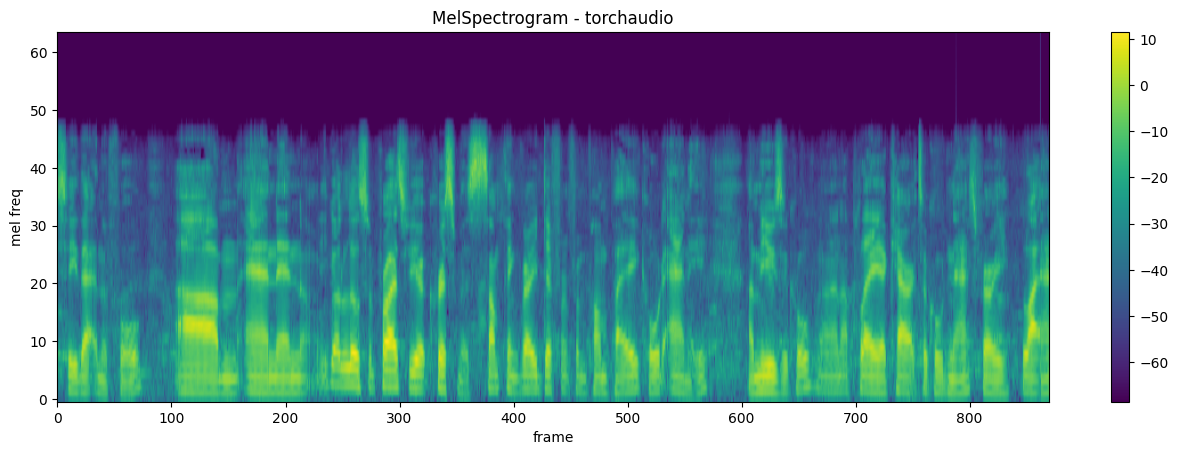

Shape: (2, 445410)
Dtype: torch.float32
 - Max:      0.308
 - Min:     -0.193
 - Mean:    -0.000
 - Std Dev:  0.030

tensor([[ 0.0013,  0.0037,  0.0088,  ..., -0.0242, -0.0225, -0.0195],
        [ 0.0013,  0.0037,  0.0088,  ..., -0.0242, -0.0225, -0.0195]])



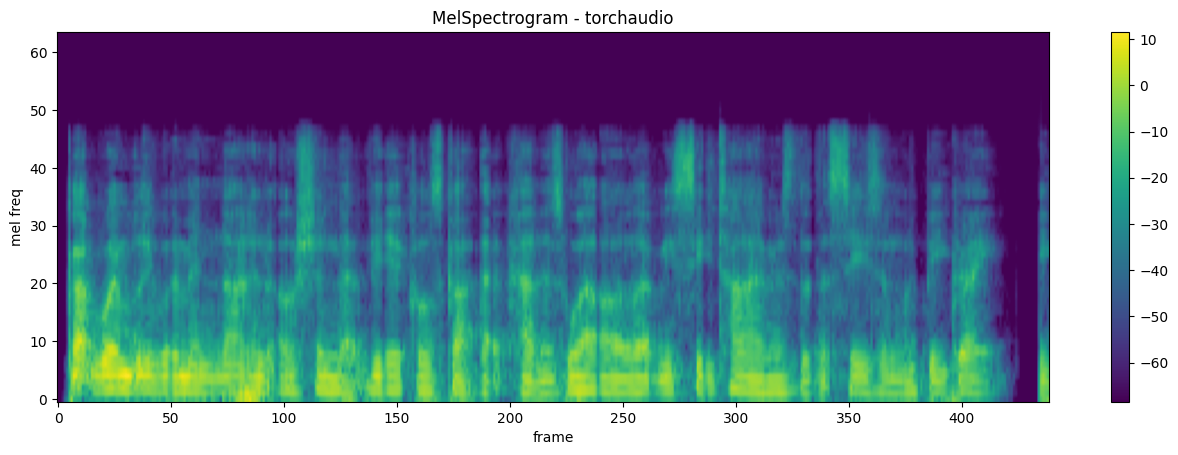

Shape: (2, 224469)
Dtype: torch.float32
 - Max:      0.365
 - Min:     -0.194
 - Mean:     0.000
 - Std Dev:  0.029

tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0272, -0.0271, -0.0269],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0272, -0.0271, -0.0269]])



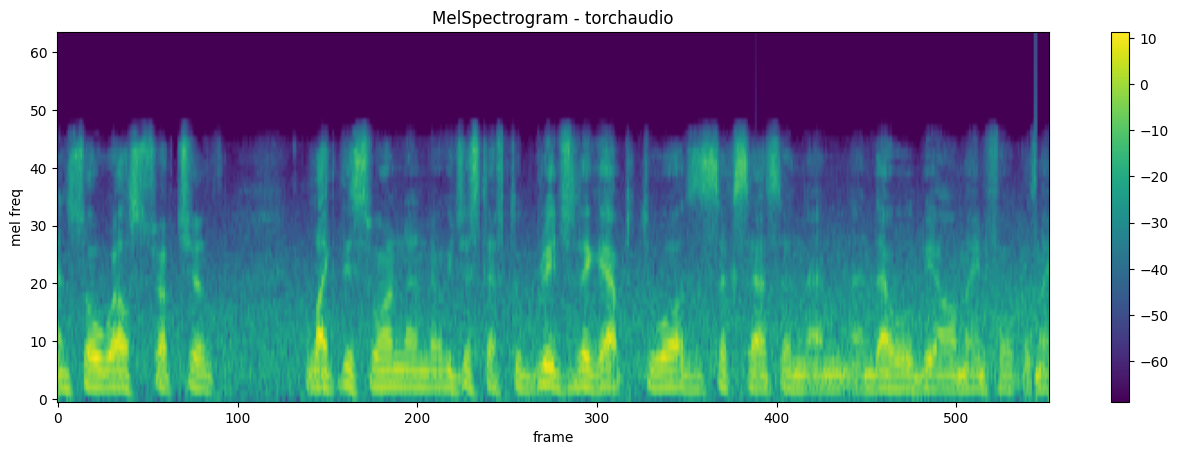

Shape: (2, 282240)
Dtype: torch.float32
 - Max:      0.261
 - Min:     -0.172
 - Mean:    -0.000
 - Std Dev:  0.032

tensor([[-0.0055, -0.0061, -0.0078,  ..., -0.0187, -0.0216, -0.0241],
        [-0.0055, -0.0061, -0.0078,  ..., -0.0187, -0.0216, -0.0241]])



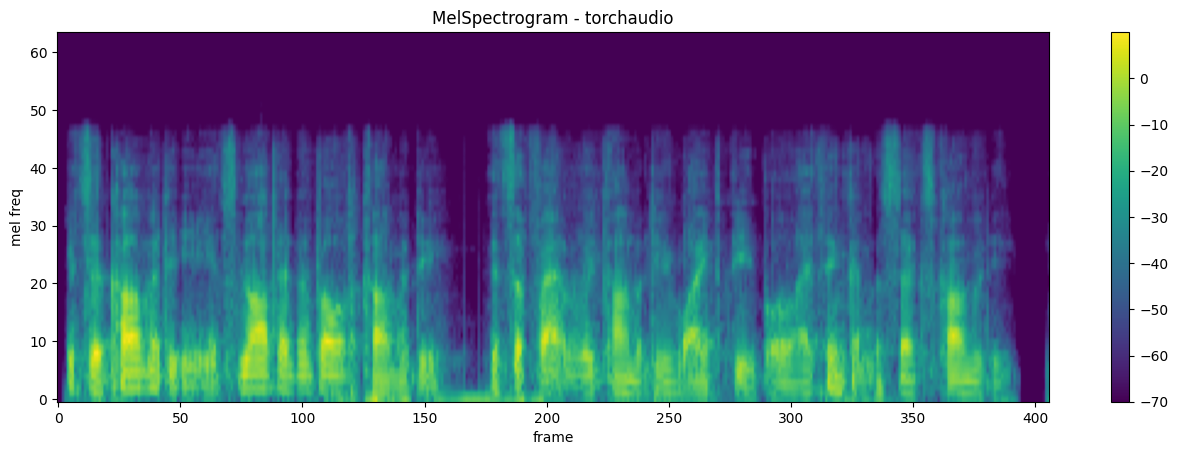

Shape: (2, 207711)
Dtype: torch.float32
 - Max:      0.191
 - Min:     -0.413
 - Mean:    -0.000
 - Std Dev:  0.024

tensor([[ 0.0000,  0.0000,  0.0000,  ..., -0.0016, -0.0016, -0.0016],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0016, -0.0016, -0.0016]])



In [9]:
#display 2 real audio files and 2 fake audio files (order: R,F,R,F)

wavPathSampleset=[dfTraining['wavLocation'][0],dfTraining['wavLocation'][10000],dfTraining['wavLocation'][3000],dfTraining['wavLocation'][12000]]
#melsprectorgram
n_fft = 1024
win_length = None
hop_length = 512
n_mels = 64
for i in range(0,4):
    waveform, sample_rate = torchaudio.load(wavPathSampleset[i])
    mel_spectrogram = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        center=True,
        pad_mode="reflect",
        power=2.0,
    norm='slaney',
        onesided=True,
    n_mels=n_mels,
    mel_scale="htk",
)

    melspec = mel_spectrogram(waveform)
    plot_spectrogram(
        melspec[0], title="MelSpectrogram - torchaudio", ylabel='mel freq')
    print_stats(waveform)